### Daytum Course: Spatial Data Analytics

### Spatial Facies Simulation

Here's a simple workflow for spatial simulation with sequential indicator simulation. This step is critical for:

1. Prediction away from spatial data with uncertainty.
2. Spatial cross validation.
3. Spatial uncertainty modeling with realistic spatial feature realizations.

We use indicator simulation for the case of categorical features and when control of spatial continuity over feature magnitude is essential for a continuous feature.

First let's explain the concept of spatial simulation.

#### Spatial Simulation

#### Load the required libraries

The following code loads the required libraries.

In [2]:
import os                                                 # to set current working directory 
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames
import matplotlib.pyplot as plt                           # plotting
import geostatspy.GSLIB as GSLIB

We will also need some standard packages. These should have been installed with Anaconda 3.

In [3]:
ignore_warnings = True                                    # ignore warnings?
import os                                                 # to set current working directory 
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames
import matplotlib.pyplot as plt                           # plotting
import matplotlib as mpl                                  # custom colorbar
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
import geostatspy.GSLIB as GSLIB
import geostatspy.geostats as geostats
plt.rc('axes', axisbelow=True)                            # plot all grids below the plot elements
if ignore_warnings == True:                                   
    import warnings
    warnings.filterwarnings('ignore')
cmap = plt.cm.inferno                                     # color map

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Define Functions

This is a convenience function to add major and minor gridlines and a combine location map and pixelplot that has color maps and color bars to improve plot interpretability.

In [5]:
def add_grid():
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks  
    
def locpix_colormaps_st(array,xmin,xmax,ymin,ymax,step,vmin,vmax,df,xcol,ycol,vcol,title,xlabel,ylabel,vlabel_loc,vlabel,cmap_loc,cmap):
    xx, yy = np.meshgrid(
        np.arange(xmin, xmax, step), np.arange(ymax, ymin, -1 * step)
    )
    cs = plt.imshow(array,interpolation = None,extent = [xmin,xmax,ymin,ymax], vmin = vmin, vmax = vmax,cmap = cmap)
    plt.scatter(df[xcol],df[ycol],s=None,c=df[vcol],marker=None,cmap=cmap_loc,vmin=vmin,vmax=vmax,alpha=0.8,linewidths=0.8,
        edgecolors="black",)
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel); plt.xlim(xmin, xmax); plt.ylim(ymin, ymax)
    cbar_loc = plt.colorbar(orientation="vertical",pad=0.08,ticks=[0, 1],
            format=mticker.FixedFormatter(['Shale','Sand'])); cbar_loc.set_label(vlabel_loc, rotation=270,labelpad=20)
    cbar = plt.colorbar(cs,orientation="vertical",pad=0.05); cbar.set_label(vlabel, rotation=270,labelpad=20)
    return cs

#### Make Custom Colorbar

We make this colorbar to display our categorical, sand and shale facies.

In [6]:
cmap_facies = mpl.colors.ListedColormap(['grey','gold'])
cmap_facies.set_over('white'); cmap_facies.set_under('white')

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time).  Also, in this case make sure to place the required (see above) GSLIB executables in this directory or a location identified in the environmental variable *Path*.

In [7]:
#os.chdir("c:/PGE383")                                     # set the working directory

#### Loading Tabular Data

Here's the command to load the data into a Pandas' DataFrame object. You can select one of the following datasets with command,

````python 
idata = 0
````

| Index       | Name             | Description                                                  |
|:-----------:|:------------------:|:--------------------------------------------------------------:|
| 0           | sample_data_biased | biased with moderate covered and one section dense, regular sampling | 
| 1           | spatial_nonlinear_MV_facies_v1 | biased with dense sampling | 
| 2           | spatial_nonlinear_MV_facies_v5_sand_only | NOT AVAILBLE FOR THIS EXERCISE |
| 3           | 12_sample_data.csv | biased sparsely sampled | 
| 4           | sample_data.csv | regular sampling 2 densely sampled study areas | 

In [8]:
idata = 1

if idata == 0:
    df = pd.read_csv(r'https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/sample_data_biased.csv') # load the data from Dr. Pyrcz's github repository
    pormax = 0.24
if idata == 1:
    df = pd.read_csv(r'https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/spatial_nonlinear_MV_facies_v1.csv') # load the data from Dr. Pyrcz's github repository
    df = df.rename(columns={'Por': 'Porosity'})  
    df['Porosity'] = df['Porosity']/100.0
    pormax = 0.24
if idata == 2:
    print("Dataset 2 is not used in this demonstration (only sand facies)")
if idata == 3:    
    df = pd.read_csv(r'https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/12_sample_data.csv') # load the data from Dr. Pyrcz's github repository
    df = df.rename(columns={'Por': 'Porosity'})  
    df = df.sample(n = 40)
    pormax = 0.30
if idata == 4:    
    df = pd.read_csv(r'https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/sample_data.csv') # load the data from Dr. Pyrcz's github repository
    df = df.rename(columns={'Por': 'Porosity'})  
#     df = df.sample(n = 40)
    pormax = 0.30

We will work by-facies, that is separating sand and shale facies and working with them separately.  This command extracts the sand and shale 'Facies" into new DataFrames for our analysis.

In [10]:
# Separate Sample Data by-facies - Deepcopy
df_sand = pd.DataFrame.copy(df[df['Facies'] == 1]).reset_index() # copy only 'Facies' = sand records
df_shale = pd.DataFrame.copy(df[df['Facies'] == 0]).reset_index() # copy only 'Facies' = shale records
df_sand.head()                                          # preview the sand only DataFrame

,index,X,Y,Porosity,Perm,AI,Facies,Facies_Names
0,0,1.219681,10.006391,0.077918,332.802662,4114.121592,1,Sand
1,1,1.400597,160.265186,0.167088,505.072608,3820.596087,1,Sand
2,2,15.497048,775.834642,0.124302,404.367985,4180.556194,1,Sand
3,4,15.873019,476.372378,0.056628,333.942714,4055.169132,1,Sand
4,5,15.928415,536.328689,0.156781,429.106569,3908.915327,1,Sand


#### PDF and CDFs

Let’s also look at the distributions, facies PDF and porosity CDF by facies.

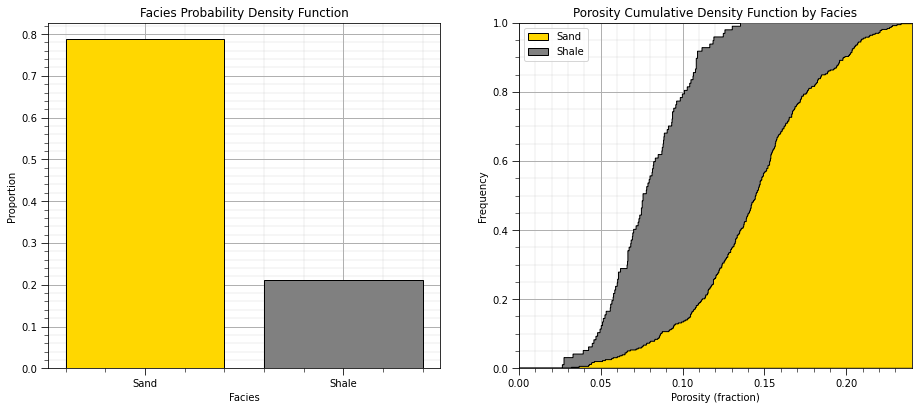

In [13]:
plt.subplot(121)
df['Facies_Names'] = np.where(df['Facies']==0,'Shale','Sand')
facies_counts = df['Facies_Names'].value_counts()/len(df); color = ['gold','grey']
plt.bar(x=['Sand','Shale'],height=facies_counts,color=color,edgecolor='black')
plt.ylabel('Proportion'); plt.xlabel('Facies'); plt.title('Facies Probability Density Function'); add_grid()

plt.subplot(122)                                              # plot original sand and shale porosity histograms
plt.hist(df_sand['Porosity'], facecolor='gold',bins=np.linspace(0.0,0.25,1000),histtype="stepfilled",
         alpha=1.0,density=True,cumulative=True,edgecolor='black',label='Sand',zorder=10)
plt.hist(df_shale['Porosity'], facecolor='grey',bins=np.linspace(0.0,0.25,1000),histtype="stepfilled",
         alpha=1.0,density=True,cumulative=True,edgecolor='black',label='Shale',zorder=9)
plt.xlim([0.0,pormax]); plt.ylim([0,1.0])
plt.xlabel('Porosity (fraction)'); plt.ylabel('Frequency'); plt.title('Porosity')
plt.legend(loc='upper left'); plt.title('Porosity Cumulative Density Function by Facies'); add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.3); plt.show()

#### Sequential Indicator Simulation

Let's jump right to building a variety of models with simulation and visualizing the results.  We will start with multiple realizations.  We will assume a variogram and use simple kriging.

Data for IK3D: Variable column Facies
  Number   = 457
Setting up rotation matrices for variogram and search
Working on realization 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Data for IK3D: Variable column Facies
  Number   = 457
Setting up rotation matrices for variogram and search
Working on realization 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Data for IK3D: Variable column Facies
  Number   = 457
Setting up rotation matrices for variogram and search
Working on realization 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   curren

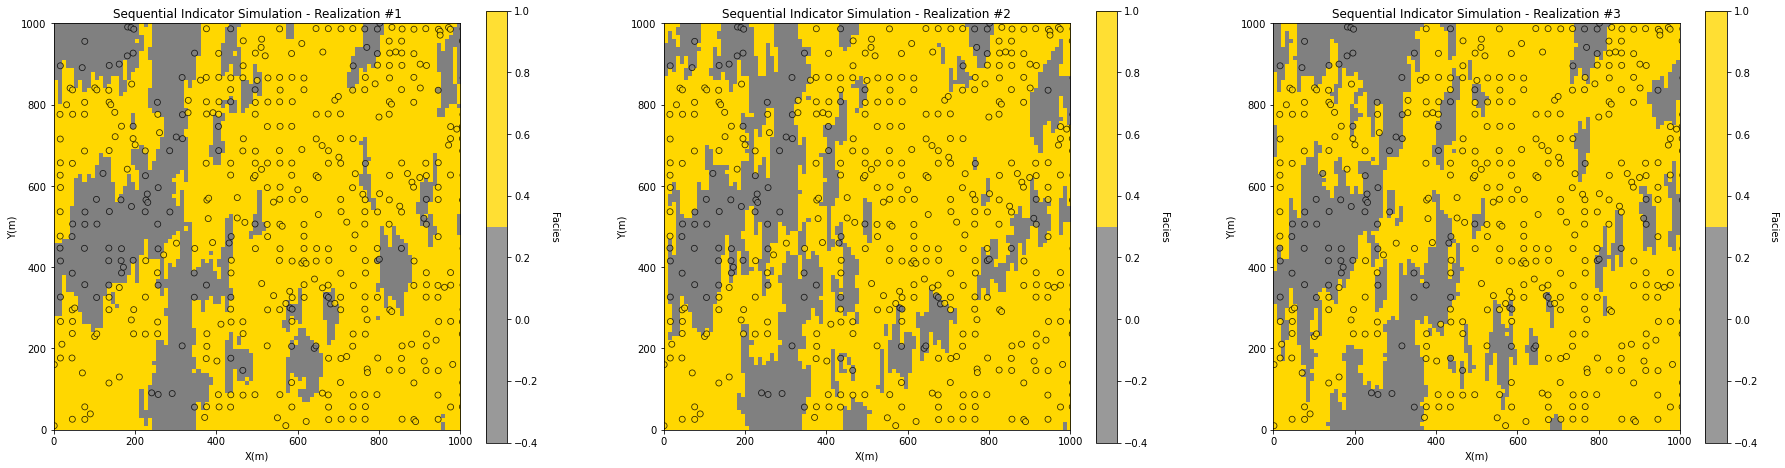

In [14]:
# Sequential Indicator Simulation with Simple Kriging Multiple Realizations 
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 5; nodmax = 10; radius = 400; skmean = 0
tmin = -999; tmax = 999
dummy_trend = np.zeros((10,10))            # the current version requires trend input - if wrong size it is ignored 

ncut = 2                                   # number of facies
thresh = [0,1]                             # the facies categories (use consisten order)
gcdf = [0.4,0.6]                           # the global proportions of the categories
varios = []                                # the variogram list
varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=400,hmin1=100)) # shale indicator variogram
varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=400,hmin1=100)) # sand indicator variogram

sim_ik1 = geostats.sisim(df,'X','Y','Facies',ivtype=0,koption=0,ncut=2,thresh=thresh,gcdf=gcdf,trend=dummy_trend,
               tmin=tmin,tmax=tmax,zmin=0.0,zmax=1.0,ltail=1,ltpar=1,middle=1,mpar=0,utail=1,utpar=2,
               nreal=1,nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed = 73073,
               ndmin=ndmin,ndmax=ndmax,nodmax=nodmax,mults=1,nmult=3,noct=-1,ktype=0,vario=varios)[0]

sim_ik2 = geostats.sisim(df,'X','Y','Facies',ivtype=0,koption=0,ncut=2,thresh=thresh,gcdf=gcdf,trend=dummy_trend,
               tmin=tmin,tmax=tmax,zmin=0.0,zmax=1.0,ltail=1,ltpar=1,middle=1,mpar=0,utail=1,utpar=2,
               nreal=1,nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed = 73074,
               ndmin=ndmin,ndmax=ndmax,nodmax=nodmax,mults=1,nmult=3,noct=-1,ktype=0,vario=varios)[0]

sim_ik3 = geostats.sisim(df,'X','Y','Facies',ivtype=0,koption=0,ncut=2,thresh=thresh,gcdf=gcdf,trend=dummy_trend,
               tmin=tmin,tmax=tmax,zmin=0.0,zmax=1.0,ltail=1,ltpar=1,middle=1,mpar=0,utail=1,utpar=2,
               nreal=1,nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed = 73075,
               ndmin=ndmin,ndmax=ndmax,nodmax=nodmax,mults=1,nmult=3,noct=-1,ktype=0,vario=varios)[0]


xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno # plotting parameters

plt.subplot(131)                                          # plot the results
GSLIB.locpix_st(sim_ik1,xmin,xmax,ymin,ymax,xsiz,-.4,1.0,df,'X','Y','Facies',
                'Sequential Indicator Simulation - Realization #1','X(m)','Y(m)','Facies',cmap_facies)
plt.subplot(132)                                          # plot the results
GSLIB.locpix_st(sim_ik2,xmin,xmax,ymin,ymax,xsiz,-.4,1.0,df,'X','Y','Facies',
                'Sequential Indicator Simulation - Realization #2','X(m)','Y(m)','Facies',cmap_facies)

plt.subplot(133)                                          # plot the results
GSLIB.locpix_st(sim_ik3,xmin,xmax,ymin,ymax,xsiz,-.4,1.0,df,'X','Y','Facies',
                'Sequential Indicator Simulation - Realization #3','X(m)','Y(m)','Facies',cmap_facies)
plt.subplots_adjust(left=0.0, bottom=0.0, right=4.0, top=1.5, wspace=0.2, hspace=0.2); plt.show()

Observe the spatial continuity, relative proportions of facies and the conditioning to the available data. Let's confirm that the representative proportions from the data are honored (the global cdf of 40% shale and 60% sand).

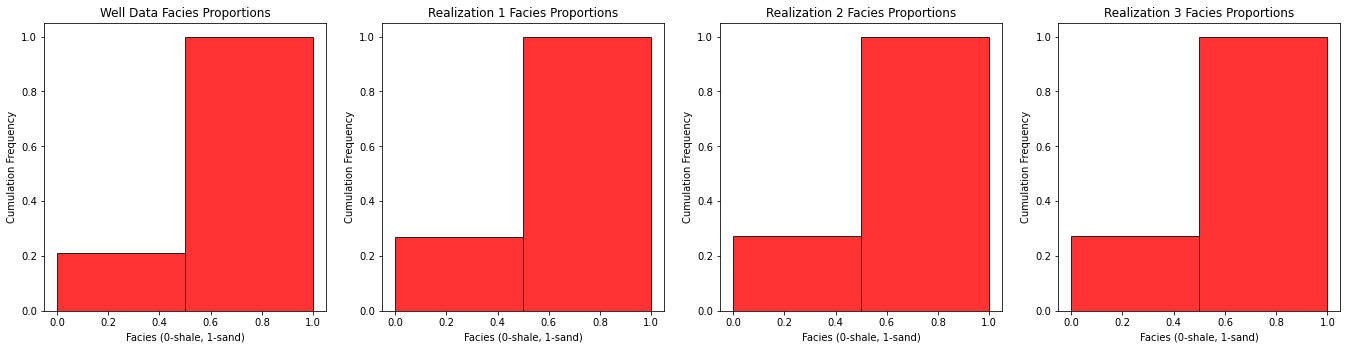

In [15]:
plt.subplot(141)
plt.hist(df['Facies'].values,bins=2,density=True,cumulative = True,alpha=0.8,color='red',edgecolor='black')
plt.xlabel('Facies (0-shale, 1-sand)')
plt.title('Well Data Facies Proportions')
plt.ylabel('Cumulation Frequency')

plt.subplot(142)
plt.hist(sim_ik1.flatten(),bins=2,density=True,cumulative = True,alpha=0.8,color='red',edgecolor='black')
plt.xlabel('Facies (0-shale, 1-sand)')
plt.title('Realization 1 Facies Proportions')
plt.ylabel('Cumulation Frequency')

plt.subplot(143)
plt.hist(sim_ik2.flatten(),bins=2,density=True,cumulative = True,alpha=0.8,color='red',edgecolor='black')
plt.xlabel('Facies (0-shale, 1-sand)')
plt.title('Realization 2 Facies Proportions')
plt.ylabel('Cumulation Frequency')

plt.subplot(144)
plt.hist(sim_ik3.flatten(),bins=2,density=True,cumulative = True,alpha=0.8,color='red',edgecolor='black')
plt.xlabel('Facies (0-shale, 1-sand)')
plt.title('Realization 3 Facies Proportions')
plt.ylabel('Cumulation Frequency')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1., wspace=0.2, hspace=0.2)
plt.savefig('hist_Porosity_Multiple_bins.tif',dpi=600,bbox_inches="tight")
plt.show()

Looks good, we have some ergodic fluctuations, but that is expected. 

#### Changing the Global Stationary Cateogrical Proportions

Let's run three realizations and significantly change the global stationary proportions and then check the results.

* the global proportion is like the mean in simple kriging

* as we move away from data, there is more weight on the global proportion

Data for IK3D: Variable column Facies
  Number   = 457
Setting up rotation matrices for variogram and search
Working on realization 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Data for IK3D: Variable column Facies
  Number   = 457
Setting up rotation matrices for variogram and search
Working on realization 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Data for IK3D: Variable column Facies
  Number   = 457
Setting up rotation matrices for variogram and search
Working on realization 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   curren

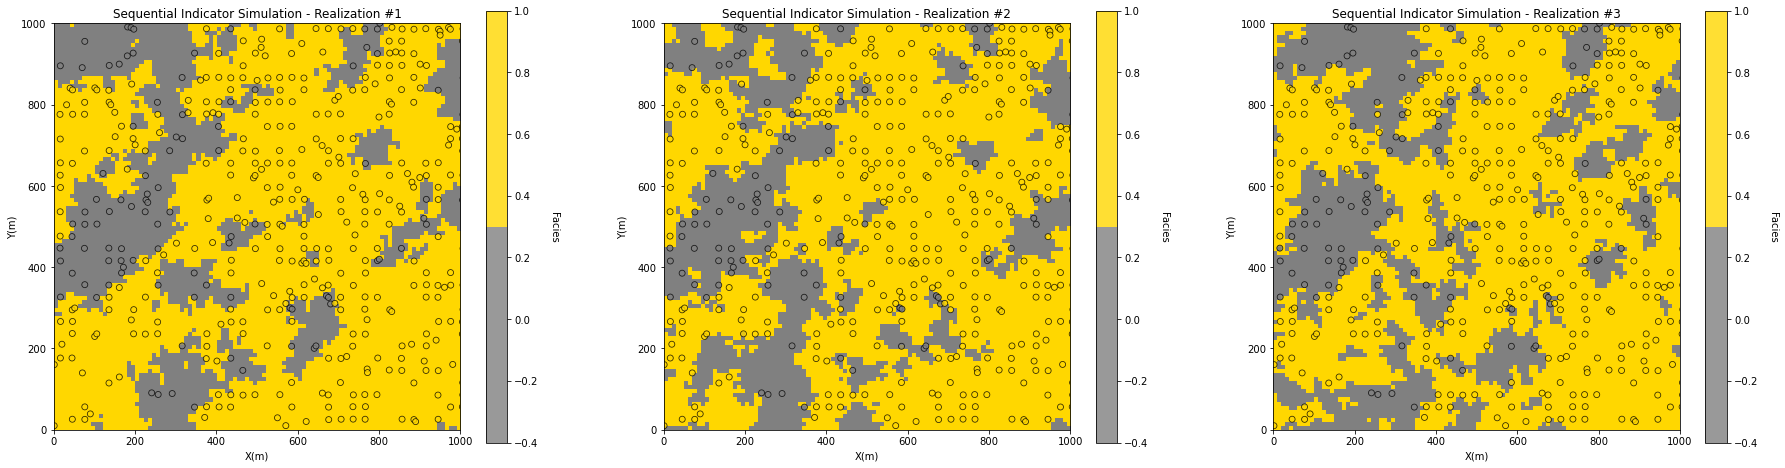

In [16]:
# Sequential Indicator Simulation with Simple Kriging Multiple Realizations 
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 5; nodmax = 10; radius = 400; skmean = 0
tmin = -999; tmax = 999
dummy_trend = np.zeros((10,10))            # the current version requires trend input - if wrong size it is ignored 

ncut = 2                                   # number of facies
thresh = [0,1]                             # the facies categories (use consisten order)
varios = []                                # the variogram list
varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=100,hmin1=100)) # shale indicator variogram
varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=100,hmin1=100)) # sand indicator variogram

gcdf1 = [0.3,0.7]                           # the global proportions of the categories
sim_ik_s1 = geostats.sisim(df,'X','Y','Facies',ivtype=0,koption=0,ncut=2,thresh=thresh,gcdf=gcdf1,trend=dummy_trend,
               tmin=tmin,tmax=tmax,zmin=0.0,zmax=1.0,ltail=1,ltpar=1,middle=1,mpar=0,utail=1,utpar=2,
               nreal=1,nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed = 73073,
               ndmin=ndmin,ndmax=ndmax,nodmax=nodmax,mults=1,nmult=3,noct=-1,ktype=0,vario=varios)[0]

gcdf2 = [0.4,0.6]                           # the global proportions of the categories
sim_ik_s2 = geostats.sisim(df,'X','Y','Facies',ivtype=0,koption=0,ncut=2,thresh=thresh,gcdf=gcdf2,trend=dummy_trend,
               tmin=tmin,tmax=tmax,zmin=0.0,zmax=1.0,ltail=1,ltpar=1,middle=1,mpar=0,utail=1,utpar=2,
               nreal=1,nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed = 73074,
               ndmin=ndmin,ndmax=ndmax,nodmax=nodmax,mults=1,nmult=3,noct=-1,ktype=0,vario=varios)[0]

gcdf3 = [0.5,0.5]                           # the global proportions of the categories
sim_ik_s3 = geostats.sisim(df,'X','Y','Facies',ivtype=0,koption=0,ncut=2,thresh=thresh,gcdf=gcdf3,trend=dummy_trend,
               tmin=tmin,tmax=tmax,zmin=0.0,zmax=1.0,ltail=1,ltpar=1,middle=1,mpar=0,utail=1,utpar=2,
               nreal=1,nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed = 73075,
               ndmin=ndmin,ndmax=ndmax,nodmax=nodmax,mults=1,nmult=3,noct=-1,ktype=0,vario=varios)[0]

xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno # plotting parameters

plt.subplot(131)                                          # plot the results
GSLIB.locpix_st(sim_ik_s1,xmin,xmax,ymin,ymax,xsiz,-.4,1.0,df,'X','Y','Facies',
                'Sequential Indicator Simulation - Realization #1','X(m)','Y(m)','Facies',cmap_facies)
plt.subplot(132)                                          # plot the results
GSLIB.locpix_st(sim_ik_s2,xmin,xmax,ymin,ymax,xsiz,-.4,1.0,df,'X','Y','Facies',
                'Sequential Indicator Simulation - Realization #2','X(m)','Y(m)','Facies',cmap_facies)

plt.subplot(133)                                          # plot the results
GSLIB.locpix_st(sim_ik_s3,xmin,xmax,ymin,ymax,xsiz,-.4,1.0,df,'X','Y','Facies',
                'Sequential Indicator Simulation - Realization #3','X(m)','Y(m)','Facies',cmap_facies)

plt.subplots_adjust(left=0.0, bottom=0.0, right=4.0, top=1.5, wspace=0.2, hspace=0.2); plt.show()

Let's check the proportions again and see how close we got to the global porportion.

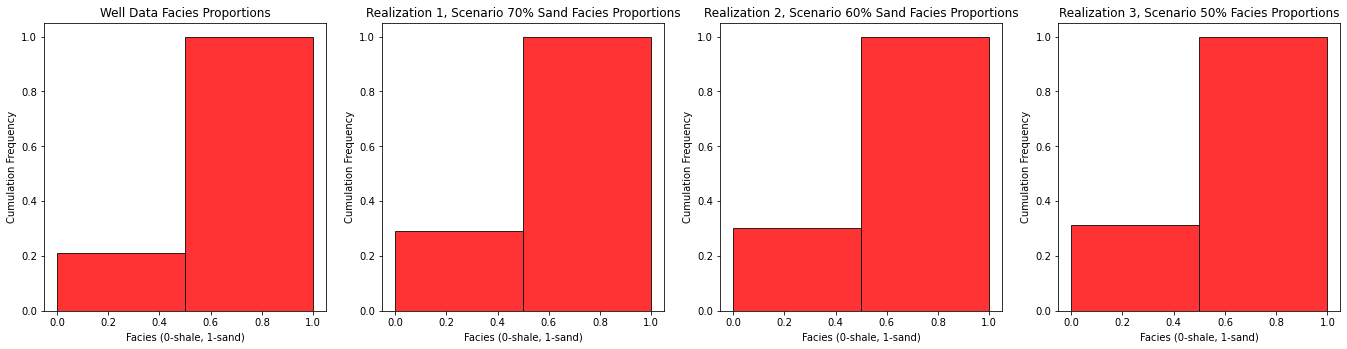

In [17]:
plt.subplot(141)
plt.hist(df['Facies'].values,bins=2,density=True,cumulative = True,alpha=0.8,color='red',edgecolor='black')
plt.xlabel('Facies (0-shale, 1-sand)')
plt.title('Well Data Facies Proportions')
plt.ylabel('Cumulation Frequency')

plt.subplot(142)
plt.hist(sim_ik_s1.flatten(),bins=2,density=True,cumulative = True,alpha=0.8,color='red',edgecolor='black')
plt.xlabel('Facies (0-shale, 1-sand)')
plt.title('Realization 1, Scenario 70% Sand Facies Proportions')
plt.ylabel('Cumulation Frequency')

plt.subplot(143)
plt.hist(sim_ik_s2.flatten(),bins=2,density=True,cumulative = True,alpha=0.8,color='red',edgecolor='black')
plt.xlabel('Facies (0-shale, 1-sand)')
plt.title('Realization 2, Scenario 60% Sand Facies Proportions')
plt.ylabel('Cumulation Frequency')

plt.subplot(144)
plt.hist(sim_ik_s3.flatten(),bins=2,density=True,cumulative = True,alpha=0.8,color='red',edgecolor='black')
plt.xlabel('Facies (0-shale, 1-sand)')
plt.title('Realization 3, Scenario 50% Facies Proportions')
plt.ylabel('Cumulation Frequency')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1., wspace=0.2, hspace=0.2)
plt.savefig('hist_Porosity_Multiple_bins.tif',dpi=600,bbox_inches="tight")
plt.show()

There may be a combination of erogodic fluctuations and control from the data.  

* if we have a high degree of spatial correlation and dense data the global proportions are constrained by the data.

#### Sequential Indicator Simulation with Ordinary Kriging

Now let's run a realization with ordinary kriging.

* relax the assumption of stationary facies proportions, estimate the local facies proportion.

Data for IK3D: Variable column Facies
  Number   = 457
Setting up rotation matrices for variogram and search
Working on realization 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000


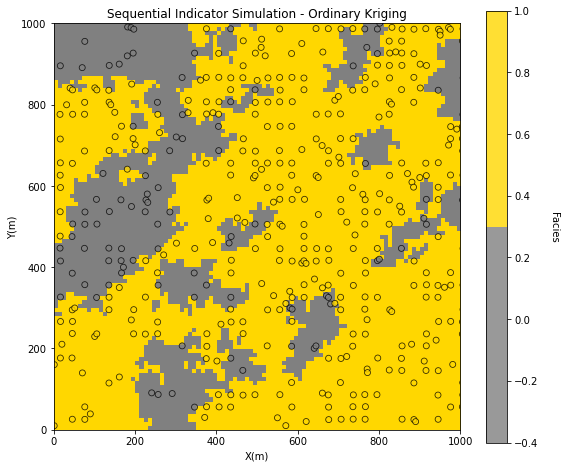

In [19]:
sim_ikok = geostats.sisim(df,'X','Y','Facies',ivtype=0,koption=0,ncut=2,thresh=thresh,gcdf=gcdf,trend=dummy_trend,
               tmin=tmin,tmax=tmax,zmin=0.0,zmax=1.0,ltail=1,ltpar=1,middle=1,mpar=0,utail=1,utpar=2,
               nreal=1,nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed = 73073,
               ndmin=ndmin,ndmax=ndmax,nodmax=nodmax,mults=1,nmult=3,noct=-1,ktype=1,vario=varios)[0]

xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno

plt.subplot(131)                                          # plot the results
GSLIB.locpix_st(sim_ikok,xmin,xmax,ymin,ymax,xsiz,-.4,1.0,df,'X','Y','Facies',
                'Sequential Indicator Simulation - Ordinary Kriging','X(m)','Y(m)','Facies',cmap_facies)

plt.subplots_adjust(left=0.0, bottom=0.0, right=4.0, top=1.5, wspace=0.2, hspace=0.2); plt.show()

#### Locally Variable Proportions / Cateogrical Trends

Next let's include a trend model, also called a locally variable proportion model in the case of categorical simulation. 

* We will make up a simple linear trend in X for demonstration. Note with kriging option 2 and a trend model with a ndarray of dimensions [ny,nx,ncut] the program will load the local proportion to apply to 1 - sum of the weights.  Note: this is not the trend / residual workflow in this first version of the program.  

We make no attempt to fit a trend to the data. 

* Let's just make up a trend model for demonstration. Here's our trend.

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 7991.89it/s]


Global proportion of shale = 0.398
Global proportion of sand = 0.602


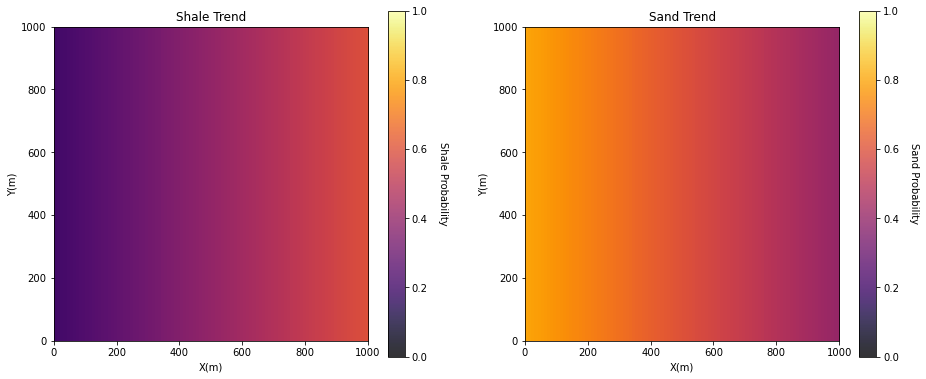

In [20]:
# Make a simple trend model
trend = np.zeros((nx,ny,ncut)); trend[:,:,0] = 0.4; trend[:,:,1] = 0.6
for iy in range(0,ny):
    for ix in range(0,nx):
        trend[iy,ix,0] = trend[iy,ix,0] + ((ix-50)/nx) * 0.4
        trend[iy,ix,1] = trend[iy,ix,1] - ((ix-50)/nx) * 0.4
        
trend = geostats.correct_trend(trend)

print('Global proportion of shale = ' + str(np.average(trend[:,:,0].flatten())) )
print('Global proportion of sand = ' +  str(np.average(trend[:,:,1].flatten())) )

plt.subplot(121)
GSLIB.pixelplt_st(trend[:,:,0],xmin,xmax,ymin,ymax,xsiz,0.0,1.0,'Shale Trend','X(m)','Y(m)','Shale Probability',cmap)

plt.subplot(122)
GSLIB.pixelplt_st(trend[:,:,1],xmin,xmax,ymin,ymax,xsiz,0.0,1.0,'Sand Trend','X(m)','Y(m)','Sand Probability',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

Before we run the simulation, let's go ahead and shorted the variogram range. This will allow us to see more influence from the trend (reduce the local data constraint).

Data for IK3D: Variable column Facies
  Number   = 457
Setting up rotation matrices for variogram and search
Working on realization 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000


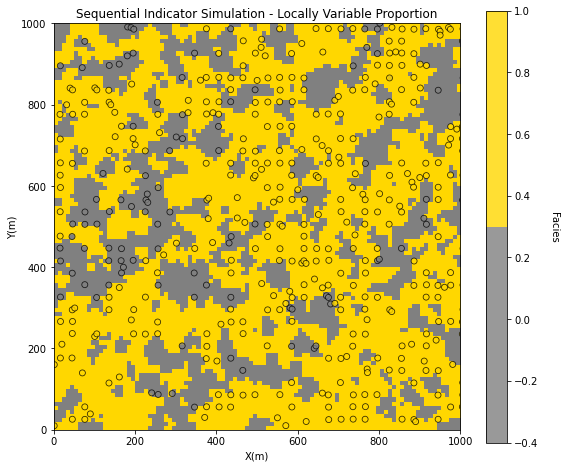

In [21]:
varios = []                                # the variogram list
varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=50,hmin1=50)) # shale indicator variogram
varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=50,hmin1=50)) # sand indicator variogram

sim_ik_trend = geostats.sisim(df,'X','Y','Facies',ivtype=0,koption=0,ncut=2,thresh=thresh,gcdf=gcdf,trend=trend,
               tmin=tmin,tmax=tmax,zmin=0.0,zmax=1.0,ltail=1,ltpar=1,middle=1,mpar=0,utail=1,utpar=2,
               nreal=1,nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed = 73073,
               ndmin=ndmin,ndmax=ndmax,nodmax=nodmax,mults=1,nmult=3,noct=-1,ktype=2,vario=varios)[0]

xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno

plt.subplot(131)                                          # plot the results
GSLIB.locpix_st(sim_ik_trend,xmin,xmax,ymin,ymax,xsiz,-.4,1.0,df,'X','Y','Facies',
                'Sequential Indicator Simulation - Locally Variable Proportion','X(m)','Y(m)','Facies',cmap_facies)

plt.subplots_adjust(left=0.0, bottom=0.0, right=4.0, top=1.5, wspace=0.2, hspace=0.2); plt.show()

The trend is quite epic. We should take care to ensure that the global proportions in the trend honor the representative statistics (from declustering).  The above exercise was just a simple demo.

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 7971.99it/s]


Low Trend: Global proportion of shale = 0.498
Low Trend: Global proportion of sand = 0.502
High Trend: Global proportion of shale = 0.298
High Trend: Global proportion of sand = 0.702


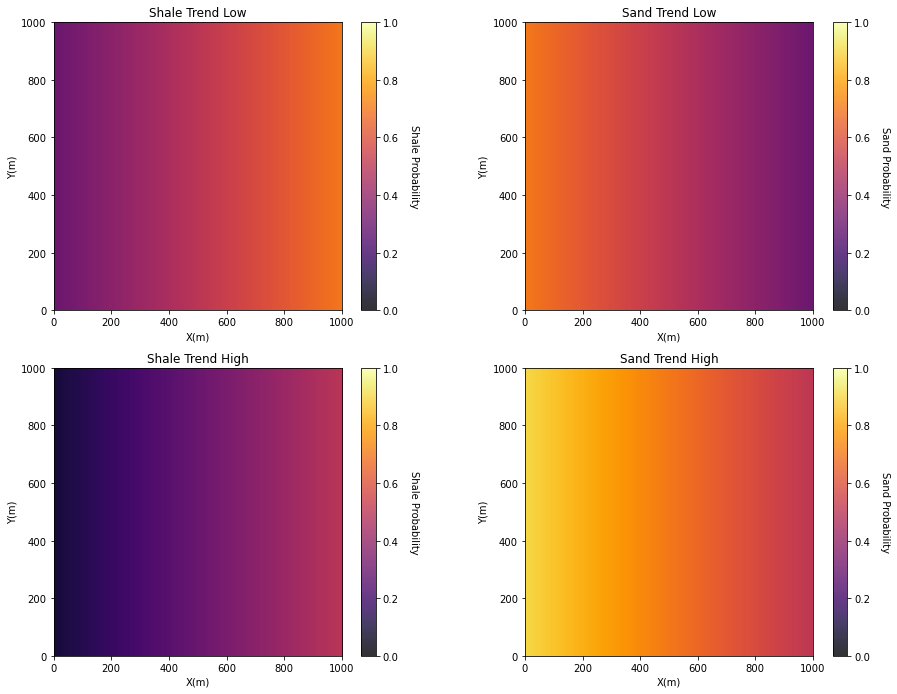

In [22]:
# using trend scenarios
trend_low = np.zeros((ny,nx,2))
trend_low[:,:,0] = trend[:,:,0] + 0.1
trend_low[:,:,1] = trend[:,:,1] - 0.1
trend_low = geostats.correct_trend(trend_low)

trend_high = np.zeros((ny,nx,2))
trend_high[:,:,0] = trend[:,:,0] - 0.1
trend_high[:,:,1] = trend[:,:,1] + 0.1
trend_high = geostats.correct_trend(trend_high)

print('Low Trend: Global proportion of shale = ' + str(np.average(trend_low[:,:,0].flatten())) )
print('Low Trend: Global proportion of sand = ' +  str(np.average(trend_low[:,:,1].flatten())) )

print('High Trend: Global proportion of shale = ' + str(np.average(trend_high[:,:,0].flatten())) )
print('High Trend: Global proportion of sand = ' +  str(np.average(trend_high[:,:,1].flatten())) )

plt.subplot(221)
GSLIB.pixelplt_st(trend_low[:,:,0],xmin,xmax,ymin,ymax,xsiz,0.0,1.0,'Shale Trend Low','X(m)','Y(m)','Shale Probability',cmap)

plt.subplot(222)
GSLIB.pixelplt_st(trend_low[:,:,1],xmin,xmax,ymin,ymax,xsiz,0.0,1.0,'Sand Trend Low','X(m)','Y(m)','Sand Probability',cmap)

plt.subplot(223)
GSLIB.pixelplt_st(trend_high[:,:,0],xmin,xmax,ymin,ymax,xsiz,0.0,1.0,'Shale Trend High','X(m)','Y(m)','Shale Probability',cmap)

plt.subplot(224)
GSLIB.pixelplt_st(trend_high[:,:,1],xmin,xmax,ymin,ymax,xsiz,0.0,1.0,'Sand Trend High','X(m)','Y(m)','Sand Probability',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.2, hspace=0.2)
plt.show()

Once again we use a shorter variogram range to observe the impact of the trend model on the realizations.

* see how the trend also constrains the global proportions.

Data for IK3D: Variable column Facies
  Number   = 457
Setting up rotation matrices for variogram and search
Working on realization 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Data for IK3D: Variable column Facies
  Number   = 457
Setting up rotation matrices for variogram and search
Working on realization 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000


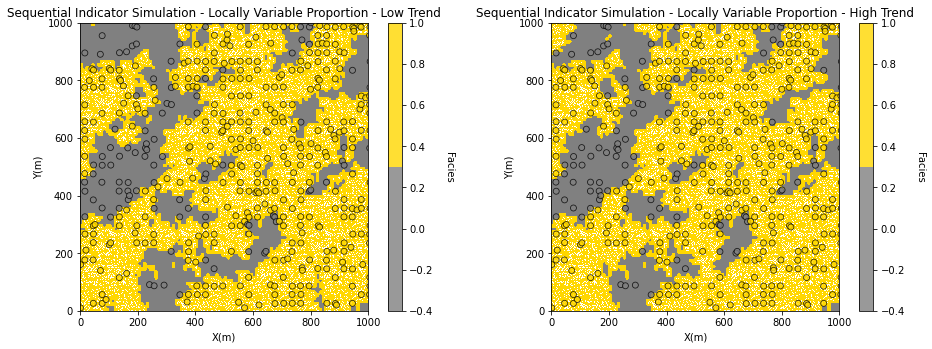

In [23]:
varios = []                                # the variogram list
varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=100,hmin1=100)) # shale indicator variogram
varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=100,hmin1=100)) # sand indicator variogram

sim_ik_lowtrend = geostats.sisim(df,'X','Y','Facies',ivtype=0,koption=0,ncut=2,thresh=thresh,gcdf=gcdf,trend=trend_low,
               tmin=tmin,tmax=tmax,zmin=0.0,zmax=1.0,ltail=1,ltpar=1,middle=1,mpar=0,utail=1,utpar=2,
               nreal=1,nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed = 73073,
               ndmin=ndmin,ndmax=ndmax,nodmax=nodmax,mults=1,nmult=3,noct=-1,ktype=2,vario=varios)[0]

sim_ik_hightrend = geostats.sisim(df,'X','Y','Facies',ivtype=0,koption=0,ncut=2,thresh=thresh,gcdf=gcdf,trend=trend_high,
               tmin=tmin,tmax=tmax,zmin=0.0,zmax=1.0,ltail=1,ltpar=1,middle=1,mpar=0,utail=1,utpar=2,
               nreal=1,nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed = 73073,
               ndmin=ndmin,ndmax=ndmax,nodmax=nodmax,mults=1,nmult=3,noct=-1,ktype=2,vario=varios)[0]

xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno

plt.subplot(121)                                          # plot the results
GSLIB.locpix_st(sim_ik_lowtrend,xmin,xmax,ymin,ymax,xsiz,-.4,1.0,df,'X','Y','Facies',
                'Sequential Indicator Simulation - Locally Variable Proportion - Low Trend','X(m)','Y(m)','Facies',cmap_facies)

plt.subplot(122)                                          # plot the results
GSLIB.locpix_st(sim_ik_hightrend,xmin,xmax,ymin,ymax,xsiz,-.4,1.0,df,'X','Y','Facies',
                'Sequential Indicator Simulation - Locally Variable Proportion - High Trend','X(m)','Y(m)','Facies',cmap_facies)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2); plt.show()

Let's check the global proportions. 

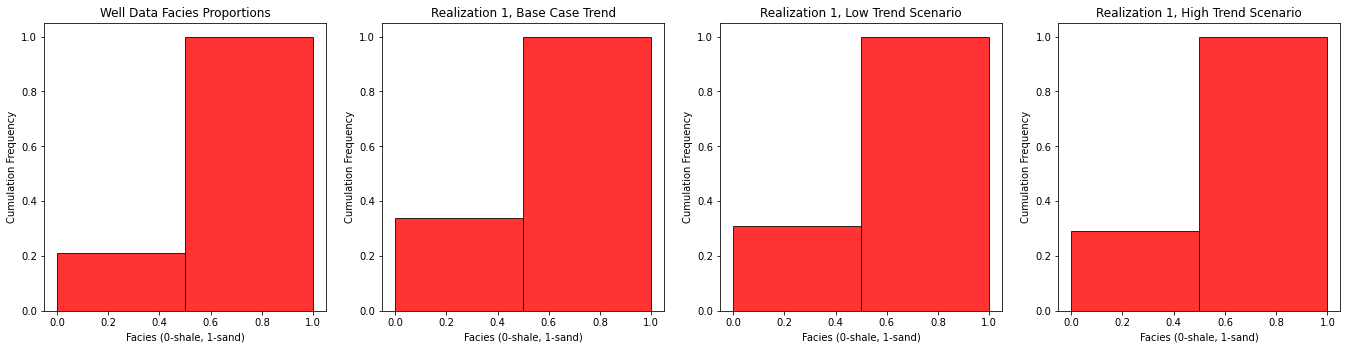

In [24]:
plt.subplot(141)
plt.hist(df['Facies'].values,bins=2,density=True,cumulative = True,alpha=0.8,color='red',edgecolor='black')
plt.xlabel('Facies (0-shale, 1-sand)')
plt.title('Well Data Facies Proportions')
plt.ylabel('Cumulation Frequency')

plt.subplot(142)
plt.hist(sim_ik_trend.flatten(),bins=2,density=True,cumulative = True,alpha=0.8,color='red',edgecolor='black')
plt.xlabel('Facies (0-shale, 1-sand)')
plt.title('Realization 1, Base Case Trend')
plt.ylabel('Cumulation Frequency')

plt.subplot(143)
plt.hist(sim_ik_lowtrend.flatten(),bins=2,density=True,cumulative = True,alpha=0.8,color='red',edgecolor='black')
plt.xlabel('Facies (0-shale, 1-sand)')
plt.title('Realization 1, Low Trend Scenario')
plt.ylabel('Cumulation Frequency')

plt.subplot(144)
plt.hist(sim_ik_hightrend.flatten(),bins=2,density=True,cumulative = True,alpha=0.8,color='red',edgecolor='black')
plt.xlabel('Facies (0-shale, 1-sand)')
plt.title('Realization 1, High Trend Scenario')
plt.ylabel('Cumulation Frequency')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1., wspace=0.2, hspace=0.2)
plt.savefig('hist_Porosity_Multiple_bins.tif',dpi=600,bbox_inches="tight")
plt.show()

The base case honour the well data proportions. While the low case boosts the shale to 50% (likely fell short due to data constraints) and the high case discounts the shale to 30%. 

#### Comments

This was a basic demonstration of spatial simulation with seuquential indicator simulation. I know the simulation program is rough and the code needs some clean up, but we are getting to the point where we have a function package for Geostatistics in Python.  

Much more could be done, I have other demonstrations on the basics of working with DataFrames, ndarrays, univariate statistics, plotting data, declustering, data transformations and many other workflows available at https://github.com/GeostatsGuy/PythonNumericalDemos and https://github.com/GeostatsGuy/GeostatsPy. 
  
I hope this was helpful,

*Michael*

#### The Author:

### Michael Pyrcz, Professor, The University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

<i>&copy; Copyright daytum 2021. All Rights Reserved</i>